In [1]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from torchvision import models
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F
#from einops import rearrange, repeat
#from einops.layers.torch import Rearrange
import math
import numpy as np
import time
from torch import einsum
import cv2
import scipy.misc
#import utils
import tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import pandas as pd

file_path = "sim_squat_data.csv"

df = pd.read_csv(file_path)

print(df.head())

   updown       UWB     vel_x     vel_y     vel_z     accel_x     accel_y  \
0       0  1.711766  0.000000  0.000000  0.000000   11.828938  -47.956334   
1       0  1.711567  0.032885 -0.103377  0.085973  161.323707  -58.555513   
2       0  1.707675  0.814416 -0.361158 -0.095207 -178.527859  131.141650   
3       0  1.706877 -0.014801  0.076857 -0.414512  167.629076 -131.972570   
4       0  1.702809  0.778336 -0.387729 -0.164145 -152.167755   50.021166   

      accel_z    gyro_x    gyro_y    gyro_z  
0   62.560536  0.000000  0.000000  0.000000  
1  -18.781445  1.277550  0.196830 -0.315507  
2 -121.957382  0.458584  2.095545 -2.194921  
3  115.180361 -2.522667  1.956186  0.759899  
4   -3.156194  1.050402  2.661206 -2.515833  


In [3]:
df = df.drop(columns=['vel_x', 'vel_y', 'vel_z'])

In [4]:
tmp = df['updown'].shift(1).fillna(0)
squat_ends = df[(tmp == 1) & (df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = df.iloc[start_index:end_index+1]

    if len(one_set) > 140:
        one_set = one_set.tail(140)
        squat_sets.append(one_set)
    else:
        print(f"Set too short: {len(one_set)}")

    #squat_sets.append(one_set)
    start_index = end_index + 1

print(f"Total sets: {len(squat_sets)}")

Total squat ends: 3000
Set too short: 140
Set too short: 140
Set too short: 138
Set too short: 135
Set too short: 139
Set too short: 140
Set too short: 138
Total sets: 2993


In [5]:
X = []
y = []
for one_set in squat_sets:
    for i in range(9, len(one_set)-15, 5):
        X.append(one_set.iloc[i-9:i+6, 1:].values)
        y.append(one_set.iloc[i]['updown'])

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(71832, 15, 7) (71832,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
class biGRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biGRU, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        #h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, 10, :]) # 과거 10개, 현재 5개
        #out = self.fc(out[:, -1, :]) # 과거 15개개

        return out

In [8]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import torch.nn.init as init
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

def initialize_gru_weights(gru):
    for name, param in gru.named_parameters():
        if 'weight' in name:
            init.xavier_uniform_(param.data)
        elif 'bias' in name:
            init.constant_(param.data, 0)

# 초기화 실행
set_seed(42)
model = biGRU(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
model.apply(initialize_weights)
initialize_gru_weights(model.gru)

In [10]:
real_df = pd.read_csv("real_squat_data.csv")
real_df = real_df.drop(columns=['timestamp', 'ExcerciseType'])

real_df = real_df[real_df['updown'] != 'Stop'].reset_index(drop=True)
real_df['updown'] = real_df['updown'].replace({'Up': 1, 'Down': 0})

real_df['UWB'] = real_df['UWB'].astype('str').str.replace('m', '').str.strip().astype('float')

real_df.head()

<ipython-input-10-7ddbcff8a578>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  real_df['updown'] = real_df['updown'].replace({'Up': 1, 'Down': 0})


,UWB,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,updown
0,1.057172,-0.011848,-0.012002,-0.005489,-0.101188,0.028084,0.004408,0
1,NaN,-0.009785,-0.027183,0.008501,-0.099331,0.023237,-0.032343,0
2,1.060005,0.008980,-0.012904,0.043463,-0.327205,0.127292,-0.068003,0
3,1.022101,0.008980,-0.012904,0.043463,-0.327205,0.127292,-0.068003,0
4,NaN,-0.015175,0.007049,0.046295,0.030420,0.153185,-0.037317,0


In [11]:
tmp = real_df['updown'].shift(1).fillna(0)
squat_ends = real_df[(tmp == 1) & (real_df['updown'] == 0)].index
print(f"Total squat ends: {len(squat_ends)}")
print(squat_ends)

squat_sets = []

start_index = 0
for end_index in squat_ends:
    one_set = real_df.iloc[start_index:end_index+1]

    squat_sets.append(one_set)
    print(f"len of oneset:{len(one_set)}")
    #squat_sets.append(one_set)
    print(f"start_index: {start_index}, end_index: {end_index}")
    start_index = end_index + 1


print(f"Total sets: {len(squat_sets)}")


Total squat ends: 46
Index([  52,   98,  150,  191,  240,  289,  339,  386,  434,  493,  543,  594,
        643,  695,  731,  787,  836,  883,  923,  968, 1017, 1059, 1099, 1141,
       1181, 1223, 1267, 1303, 1355, 1409, 1468, 1515, 1554, 1591, 1636, 1677,
       1724, 1765, 1809, 1863, 1903, 1952, 1998, 2043, 2069, 2120],
      dtype='int64')
len of oneset:53
start_index: 0, end_index: 52
len of oneset:46
start_index: 53, end_index: 98
len of oneset:52
start_index: 99, end_index: 150
len of oneset:41
start_index: 151, end_index: 191
len of oneset:49
start_index: 192, end_index: 240
len of oneset:49
start_index: 241, end_index: 289
len of oneset:50
start_index: 290, end_index: 339
len of oneset:47
start_index: 340, end_index: 386
len of oneset:48
start_index: 387, end_index: 434
len of oneset:59
start_index: 435, end_index: 493
len of oneset:50
start_index: 494, end_index: 543
len of oneset:51
start_index: 544, end_index: 594
len of oneset:49
start_index: 595, end_index: 643
len of on

In [12]:
for one_set in squat_sets:
    one_set['UWB'] = one_set['UWB'].interpolate(method='linear', limit_direction='both')

<ipython-input-12-f3fc64f554d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_set['UWB'] = one_set['UWB'].interpolate(method='linear', limit_direction='both')


In [13]:
X_test = []
y_test = []

for one_set in squat_sets:
    for i in range(9, len(one_set)-15, 5):
        X_test.append(one_set.iloc[i-9:i+6, 1:].values)
        y_test.append(one_set.iloc[i]['updown'])

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(222, 15, 7) (222,)


In [14]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
num_classes = 2
input_size = 7
hidden_size = 128
num_layers = 2
seq_length = 15

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [16]:
print(model)

biGRU(
  (gru): GRU(7, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [17]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [18]:
def evaluate(model, data_loader, criterion, device, phase="validation"):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"Evaluating {phase}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Accuracy: {accuracy:.2f}%")
    if phase == "validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
    if phase == "test":
        test_accuracy = accuracy
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        f1_score_result = f1_score(all_labels, all_predictions)
        recall_score_result = recall_score(all_labels, all_predictions)
        precision_score_result = precision_score(all_labels, all_predictions)

        return f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions

In [19]:
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="validation")

Epoch [1/50]


Train Loss: 0.0048, Train Accuracy: 93.49%


Validation Loss: 0.0022, Validation Accuracy: 97.72%
Best model saved!
Epoch [2/50]


Train Loss: 0.0017, Train Accuracy: 98.03%


Validation Loss: 0.0015, Validation Accuracy: 97.91%
Best model saved!
Epoch [3/50]


Train Loss: 0.0012, Train Accuracy: 98.56%


Validation Loss: 0.0013, Validation Accuracy: 98.42%
Best model saved!
Epoch [4/50]


Train Loss: 0.0010, Train Accuracy: 98.89%


Validation Loss: 0.0009, Validation Accuracy: 98.97%
Best model saved!
Epoch [5/50]


Train Loss: 0.0008, Train Accuracy: 99.11%


Validation Loss: 0.0015, Validation Accuracy: 97.83%
Epoch [6/50]


Train Loss: 0.0007, Train Accuracy: 99.28%


Validation Loss: 0.0008, Validation Accuracy: 99.14%
Best model saved!
Epoch [7/50]


Train Loss: 0.0006, Train Accuracy: 99.32%


Validation Loss: 0.0008, Validation Accuracy: 99.26%
Best model saved!
Epoch [8/50]


Train Loss: 0.0005, Train Accuracy: 99.43%


Validation Loss: 0.0007, Validation Accuracy: 99.25%
Epoch [9/50]


Train Loss: 0.0004, Train Accuracy: 99.50%


Validation Loss: 0.0008, Validation Accuracy: 99.07%
Epoch [10/50]


Train Loss: 0.0004, Train Accuracy: 99.54%


Validation Loss: 0.0006, Validation Accuracy: 99.39%
Best model saved!
Epoch [11/50]


Train Loss: 0.0004, Train Accuracy: 99.57%


Validation Loss: 0.0011, Validation Accuracy: 99.03%
Epoch [12/50]


Train Loss: 0.0003, Train Accuracy: 99.65%


Validation Loss: 0.0012, Validation Accuracy: 98.45%
Epoch [13/50]


Train Loss: 0.0003, Train Accuracy: 99.63%


Validation Loss: 0.0005, Validation Accuracy: 99.39%
Epoch [14/50]


Train Loss: 0.0003, Train Accuracy: 99.71%


Validation Loss: 0.0007, Validation Accuracy: 99.21%
Epoch [15/50]


Train Loss: 0.0002, Train Accuracy: 99.77%


Validation Loss: 0.0007, Validation Accuracy: 99.21%
Epoch [16/50]


Train Loss: 0.0002, Train Accuracy: 99.76%


Validation Loss: 0.0007, Validation Accuracy: 99.34%
Epoch [17/50]


Train Loss: 0.0002, Train Accuracy: 99.79%


Validation Loss: 0.0006, Validation Accuracy: 99.32%
Epoch [18/50]


Train Loss: 0.0002, Train Accuracy: 99.81%


Validation Loss: 0.0009, Validation Accuracy: 99.06%
Epoch [19/50]


Train Loss: 0.0002, Train Accuracy: 99.82%


Validation Loss: 0.0007, Validation Accuracy: 99.32%
Epoch [20/50]


Train Loss: 0.0001, Train Accuracy: 99.85%


Validation Loss: 0.0006, Validation Accuracy: 99.41%
Best model saved!
Epoch [21/50]


Train Loss: 0.0001, Train Accuracy: 99.85%


Validation Loss: 0.0005, Validation Accuracy: 99.44%
Best model saved!
Epoch [22/50]


Train Loss: 0.0001, Train Accuracy: 99.85%


Validation Loss: 0.0006, Validation Accuracy: 99.39%
Epoch [23/50]


Train Loss: 0.0001, Train Accuracy: 99.91%


Validation Loss: 0.0006, Validation Accuracy: 99.46%
Best model saved!
Epoch [24/50]


Train Loss: 0.0001, Train Accuracy: 99.87%


Validation Loss: 0.0006, Validation Accuracy: 99.49%
Best model saved!
Epoch [25/50]


Train Loss: 0.0001, Train Accuracy: 99.87%


Validation Loss: 0.0006, Validation Accuracy: 99.47%
Epoch [26/50]


Train Loss: 0.0001, Train Accuracy: 99.92%


Validation Loss: 0.0007, Validation Accuracy: 99.42%
Epoch [27/50]


Train Loss: 0.0001, Train Accuracy: 99.94%


Validation Loss: 0.0006, Validation Accuracy: 99.48%
Epoch [28/50]


Train Loss: 0.0001, Train Accuracy: 99.90%


Validation Loss: 0.0007, Validation Accuracy: 99.30%
Epoch [29/50]


Train Loss: 0.0001, Train Accuracy: 99.95%


Validation Loss: 0.0009, Validation Accuracy: 99.20%
Epoch [30/50]


Train Loss: 0.0001, Train Accuracy: 99.94%


Validation Loss: 0.0009, Validation Accuracy: 99.14%
Epoch [31/50]


Train Loss: 0.0001, Train Accuracy: 99.92%


Validation Loss: 0.0007, Validation Accuracy: 99.47%
Epoch [32/50]


Train Loss: 0.0001, Train Accuracy: 99.92%


Validation Loss: 0.0006, Validation Accuracy: 99.40%
Epoch [33/50]


Train Loss: 0.0001, Train Accuracy: 99.94%


Validation Loss: 0.0006, Validation Accuracy: 99.48%
Epoch [34/50]


Train Loss: 0.0001, Train Accuracy: 99.92%


Validation Loss: 0.0007, Validation Accuracy: 99.50%
Best model saved!
Epoch [35/50]


Train Loss: 0.0000, Train Accuracy: 99.98%


Validation Loss: 0.0007, Validation Accuracy: 99.49%
Epoch [36/50]


Train Loss: 0.0001, Train Accuracy: 99.93%


Validation Loss: 0.0006, Validation Accuracy: 99.52%
Best model saved!
Epoch [37/50]


Train Loss: 0.0000, Train Accuracy: 99.96%


Validation Loss: 0.0008, Validation Accuracy: 99.32%
Epoch [38/50]


Train Loss: 0.0001, Train Accuracy: 99.96%


Validation Loss: 0.0007, Validation Accuracy: 99.39%
Epoch [39/50]


Train Loss: 0.0000, Train Accuracy: 99.98%


Validation Loss: 0.0007, Validation Accuracy: 99.55%
Best model saved!
Epoch [40/50]


Train Loss: 0.0001, Train Accuracy: 99.93%


Validation Loss: 0.0006, Validation Accuracy: 99.46%
Epoch [41/50]


Train Loss: 0.0000, Train Accuracy: 99.96%


Validation Loss: 0.0006, Validation Accuracy: 99.55%
Epoch [42/50]


Train Loss: 0.0000, Train Accuracy: 99.95%


Validation Loss: 0.0006, Validation Accuracy: 99.51%
Epoch [43/50]


Train Loss: 0.0001, Train Accuracy: 99.95%


Validation Loss: 0.0006, Validation Accuracy: 99.44%
Epoch [44/50]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation Loss: 0.0007, Validation Accuracy: 99.53%
Epoch [45/50]


Train Loss: 0.0001, Train Accuracy: 99.94%


Validation Loss: 0.0007, Validation Accuracy: 99.47%
Epoch [46/50]


Train Loss: 0.0000, Train Accuracy: 99.99%


Validation Loss: 0.0006, Validation Accuracy: 99.49%
Epoch [47/50]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation Loss: 0.0006, Validation Accuracy: 99.58%
Best model saved!
Epoch [48/50]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation Loss: 0.0007, Validation Accuracy: 99.58%
Epoch [49/50]


Train Loss: 0.0001, Train Accuracy: 99.90%


Validation Loss: 0.0006, Validation Accuracy: 99.51%
Epoch [50/50]


Train Loss: 0.0000, Train Accuracy: 100.00%


Validation Loss: 0.0006, Validation Accuracy: 99.59%
Best model saved!


In [21]:
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
f1_score_result, recall_score_result, precision_score_result, all_labels, all_predictions = evaluate(model, test_loader, criterion, device, phase="test")

Test Loss: 0.1931, Test Accuracy: 46.85%
Test Accuracy: 46.85%


In [22]:
print(f"F1 Score: {f1_score_result:.4f}")
print(f"Recall Score: {recall_score_result:.4f}")
print(f"Precision Score: {precision_score_result:.4f}")

F1 Score: 0.0000
Recall Score: 0.0000
Precision Score: 0.0000


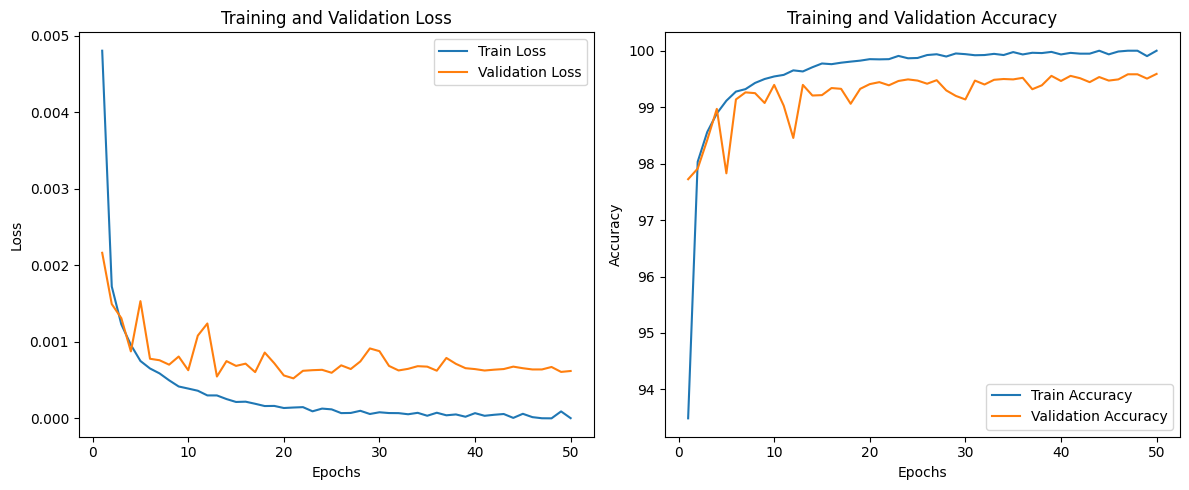

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss}
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()